Possíveis ideias para melhoras:
 - Testar modelos diferentes
 - Testar modelos com subsets das variáveis
 - Testar outros tipos de ensemble
 - Testar mais hiperparâmetros nos modelos usados
 - Testar os modelos com as saídas das camadas de embedding da rede neural
 - Fazer mais feature engineering

Avanços:
 - Fazer uma submissão

## Leitura de dados

In [217]:
import pandas as pd
from glob import glob
import numpy as np
import csv
from tqdm import tqdm
import os
from matplotlib import pyplot as plt

# definindo o nome do arquivo reduzido de treino
filename_train_reduced  = r'data\reduced_training_set.csv'

# definindo os nomes dos arquivos chunkificados
filename_train_new = r'data\chunks\train.csv'
filename_test_new = r'data\chunks\test.csv'
if not os.path.isdir(os.path.dirname(filename_test_new)):
    os.makedirs(os.path.dirname(filename_test_new))


# definindo se leremos o arquivo de treino inteiro ou apenas uma parcela dele
entire_file = False

# definindo se rodaremos a função que diminue o arquivo
run_function = 0

# proporção de linhas que entram no dataset reduzido
proportion = 0.1

# definindo a coluna y
y_column = 'is_attributed'

# definindo se vamos olhar apenas para o arquivo sample
sample_only = True

# chunkified
chunkified = False

# Se vamos usar a coluna ip
use_ip = False

In [112]:
# definição de funções

# função que reduz o dataset
def red_csv(filename_original, filename_new, proportion):
    with open(filename_original, 'r') as fo:
        with open(filename_new, 'w') as fn:
            csv_reader = csv.reader(fo)
            csv_writer = csv.writer(fn)
            first_line = next(csv_reader)
            csv_writer.writerow(first_line)
            for row in tqdm(csv_reader):
                if np.random.binomial(1, proportion):
                    csv_writer.writerow(row)

def red_csv2(filename_original, filename_new, proportion):
    columns = pd.read_csv(filename_original, nrows=1)
    with open(filename_new, 'w') as fn:
        csv_writer = csv.writer(fn)
        csv_writer.writerow(list(columns))
        for chunk in tqdm(pd.read_csv(filename_original, chunksize=10000000)):
            s = chunk.sample(int(chunk.shape[0]*proportion))
            csv_writer.writerows(s.values.tolist())
            
def split_train_in_files(filename_original, filename_train_new, filename_test_new, proportion):
    columns = pd.read_csv(filename_original, nrows=1)
    with open(filename_train_new, 'w') as ftn:
        with open(filename_test_new, 'w') as ftestn:
            csv_writer_train = csv.writer(ftn)
            csv_writer_test = csv.writer(ftestn)
            
            csv_writer_train.writerow(list(columns))
            csv_writer_test.writerow(list(columns))
            
            for chunk in tqdm(pd.read_csv(filename_original, chunksize=10000000)):
                sample_test = chunk.sample(int(chunk.shape[0]*proportion))
                sample_train = chunk[~chunk.index.isin(list(sample_test.index))]
                
                csv_writer_train.writerows(sample_train.values.tolist())
                csv_writer_test.writerows(sample_test.values.tolist())
            
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# função que treina, prediz, e  calcula o roc_auc
def train_and_predict(model, X_train = '', y_train = '', X_test = '', y_test = '', prob=False, chunkified = False, partial = False):
    if chunkified:
        for chunk in tqdm(pd.read_csv(filename_train_new, dtype=type_dict, parse_dates=['click_time'], 
                                      usecols=usecols, chunksize=1000000)):
            extract_time_features(chunk, 'click_time')
            X = chunk[[col for col in chunk.columns if col != y_column]].copy()
            y = chunk[y_column].copy()
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            if partial:
                model.partial_fit(X_train, y_train)
            else:
                model.fit(X_train, y_train)
            
            if prob:
                predictions_train = model.predict_proba(X_train)[:,1]
                predictions_test = model.predict_proba(X_test)[:,1]
            else:
                predictions_train = model.predict(X_train)            
                predictions_test = model.predict(X_test)
            
            roc_auc_train = roc_auc_score(y_train, predictions_train)
            roc_auc_test = roc_auc_score(y_test, predictions_test)
            print('ROC-AUC no treino: ', roc_auc_train)
            print('ROC-AUC no teste deste chunk: ', roc_auc_test)
    else:
        model.fit(X_train, y_train)
        predictions_train = model.predict(X_train)
    #     conf_matrix_train = confusion_matrix(y_train, predictions_train)
    #     report_train = classification_report(y_train, predictions_train)
        roc_auc_train = roc_auc_score(y_train, predictions_train)

        predictions_test = model.predict(X_test)
    #     conf_matrix_test = confusion_matrix(y_test, predictions_test)
    #     report_test = classification_report(y_test, predictions_test)
        roc_auc_test = roc_auc_score(y_test, predictions_test)
    return roc_auc_train, roc_auc_test

from sklearn.base import clone

# função que treina um modelo para cada chunk do arquivo; depois podemos fazer uma média dos modelos
def ensemble_chunks(model, X_train = '', y_train = '', X_test = '', y_test = '', prob=False):
    model_list = []
    for chunk in tqdm(pd.read_csv(filename_train_new, dtype=type_dict, parse_dates=['click_time'], 
                                      usecols=usecols, chunksize=1000000)):
            extract_time_features(chunk, 'click_time')
            X = chunk[[col for col in chunk.columns if col != y_column]].copy()
            y = chunk[y_column].copy()
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            model.fit(X_train, y_train)
            
            if prob:
                predictions_train = model.predict_proba(X_train)[:,1]
                predictions_test = model.predict_proba(X_test)[:,1]
            else:
                predictions_train = model.predict(X_train)            
                predictions_test = model.predict(X_test)
            
            roc_auc_train = roc_auc_score(y_train, predictions_train)
            roc_auc_test = roc_auc_score(y_test, predictions_test)
            print('ROC-AUC no treino: ', roc_auc_train)
            print('ROC-AUC no teste deste chunk: ', roc_auc_test)
            model_list.append(clone(model))
    return model_list

from keras.callbacks import Callback

# classe que calcula o roc_auc como callback do fit do keras
# Vamos importar esse callback para tratar o metódo fit.
from keras.callbacks import Callback

# Vamos trazer o roc_auc do sklearn para nos ajudar a calcular a métrica
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    '''
        Aqui vamos tratar o final do metodo fit do keras, vamos calcular 
        o roc_auc_score no final do fit
    '''
    


    def __init__(self,train_chunk_x,train_chunk_y, cols, test_files=[]):
        # Vamos inicializar os dados de entrada do modelo e o rótulo, bem como
        # os índices do csv que serão nossa validação
        self.x = train_chunk_x
        self.y = train_chunk_y
        val = pd.concat([pd.read_csv(file, 
                                          dtype=type_dict, 
                                          parse_dates=['click_time'], 
                                          usecols=usecols) for file in test_files],
                                   axis=0)
        extract_time_features(val, 'click_time')
        
        # Separamos entrada e dados que queremos prever
        self.val_x = [val[col] for col in cols]
        self.val_y = val['is_attributed'].values
        

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        # Calculamos as previsões para o treinamento
        y_pred = self.model.predict(self.x, batch_size=16394 * 2)
        
        # Calculamos o auc de treino
        roc_train = roc_auc_score(y_true=self.y, y_score=y_pred)        
        
        # Calculamos a previsão para o conjunto de validação
        y_pred = self.model.predict(self.val_x, batch_size=16394 * 2)
        
        # Calculamos o auc de validação
        roc_test = roc_auc_score(y_true=self.val_y, y_score=y_pred)

        # Printamos em um formato bonitinho
        print('\nroc_train: {:.4f}'.format(roc_train))
        print('roc_test: {:.4f}'.format(roc_test))
        
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [113]:
# vendo os arquivos disponiveis da pasta de dados
filenames = glob('data\*csv')
print(filenames)

['data\\reduced_training_set.csv', 'data\\sample_submission.csv', 'data\\test.csv', 'data\\train.csv', 'data\\train_sample.csv']


In [114]:
# lendo o arquivo de sample de treino
filename_train_sample = [f for f in filenames if 'train_sample' in f][0]
df_train_sample = pd.read_csv(filename_train_sample)

# transformando a coluna
df_train_sample['click_time'] = pd.to_datetime(df_train_sample.click_time)

# visualizando os dados
df_train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [205]:
# lendo o arquivo de treino
filename_train = [f for f in filenames if 'train' in f and 'sample' not in f and 'reduced' not in f][0]

# primeiro vamos ler algumas linhas, para poder setar os tipos das variáveis
df_train = pd.read_csv(filename_train, nrows = 100)

# definindo os tipos de colunas que iremos ler
type_dict = {}
for col in df_train.columns:
    type_dict[col] = np.dtype('int16')
    if col == 'ip':
        type_dict[col] = np.dtype('int32')
    elif col == 'click_time' or col == 'attributed_time':
        continue
        type_dict[col] = np.datetime64
    elif col == 'is_attributed':
        type_dict[col] = np.dtype('int8')

# definindo as colunas que não leremos
usecols = [col for col in list(df_train.columns) if col != 'attributed_time' ]
if not use_ip:
    usecols = [x for x in usecols if x != 'ip']

# reduzindo o dataset
if run_function == 1:
    red_csv(filename_train, filename_train_reduced, proportion)
elif run_function == 2:
    red_csv2(filename_train, filename_train_reduced, proportion)
elif run_function == 3:
    split_train_in_files(filename_train, filename_train_new, filename_test_new, proportion)   


# lendo o arquivo
if entire_file:
    df_train = pd.read_csv(filename_train, dtype=type_dict, parse_dates=['click_time'], usecols=usecols)
elif sample_only:
    df_train = pd.read_csv(filename_train_sample, dtype=type_dict, parse_dates=['click_time'], usecols=usecols)
elif chunkified:
    pass
else:
    df_train = pd.read_csv(filename_train_reduced, dtype=type_dict, parse_dates=['click_time'], usecols=usecols)

# visualizando os dados
df_train.head()

,app,device,os,channel,click_time,is_attributed
0,12,1,13,497,2017-11-07 09:30:38,0
1,25,1,17,259,2017-11-07 13:40:27,0
2,12,1,19,212,2017-11-07 18:05:24,0
3,13,1,13,477,2017-11-07 04:58:08,0
4,12,1,1,178,2017-11-09 09:00:09,0


In [117]:
# lendo o arquivo de teste
filename_test = [f for f in filenames if 'test' in f][0]
amostra = pd.read_csv(filename_test, nrows=1)
test_cols = [x for x in usecols if y_column not in x]
df_test = pd.read_csv(filename_test, dtype=type_dict, parse_dates=['click_time'], usecols=test_cols)

# visualizando os dados
df_test.head()    

,app,device,os,channel,click_time
0,9,1,3,107,2017-11-10 04:00:00
1,9,1,3,466,2017-11-10 04:00:00
2,21,1,19,128,2017-11-10 04:00:00
3,15,1,13,111,2017-11-10 04:00:00
4,12,1,13,328,2017-11-10 04:00:00


## Breve visualização dos dados

{0: 184447044, 1: 456846}


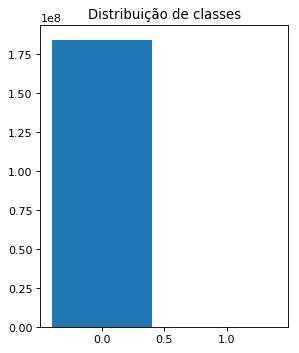

{'app': 706, 'device': 3475, 'os': 800, 'channel': 202, 'click_time': 4}


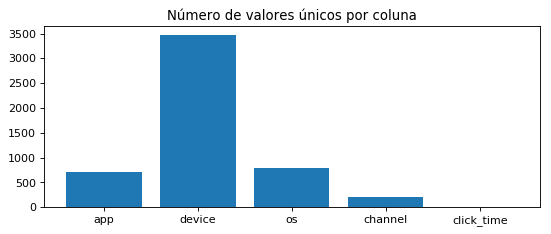

In [256]:
# desbalanço de classes
try:
    if not dist:
        dist = {}
        dist[0], dist[1] = 0, 0

        unique_dict = {}
        for col in df_train.columns:
            unique_dict[col] = []

        for chunk in tqdm(pd.read_csv(filename_train, usecols=usecols, chunksize=1000000)):
            for col in chunk.columns:
                if col == y_column:
                    dist[0] += chunk[y_column].value_counts()[0]
                    dist[1] += chunk[y_column].value_counts()[1]
                elif col == 'click_time':
                    unique_dict[col] = list(set(unique_dict[col] + [str(t).split()[0] for t in chunk[col].unique()]))
                else:
                    unique_dict[col] = list(set(unique_dict[col] + list(chunk[col].unique())))
except:
    pass

print(dist)
plt.figure(num=None, figsize=(4, 5), dpi=80, facecolor='w', edgecolor='k')
plt.bar(dist.keys(), dist.values())

plt.title('Distribuição de classes')
plt.show()

to_plot_dict = {key:len(unique_dict[key]) for key in unique_dict.keys() if key!= y_column}
print(to_plot_dict)
plt.figure(num=None, figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')

plt.bar(to_plot_dict.keys(), to_plot_dict.values())
plt.title('Número de valores únicos por coluna')
plt.show()

## Feature Engineering

In [134]:
# pela descrição dos dados, as colunas ip, app, device, os, channel são categóricas
# vamos criar colunas dummy para tratar isso
if use_ip:
    cat_cols = ['ip', 'app', 'device', 'os', 'channel']
else:
    cat_cols = ['app', 'device', 'os', 'channel']

# função que dummifica as colunas
def dummify_column(column_name, n, df, least_common = ''):
    if df[column_name].value_counts().__len__() > n:
        if not least_common:
            least_common = list(df[column_name].value_counts().index[n:])
        df.loc[df[column_name].isin(least_common), column_name] = -1
    tmp_df = pd.get_dummies(df[column_name])
    for col in tmp_df.columns:
        tmp_df[col] = tmp_df[col].astype(np.dtype('int8'))

    tmp_df.columns = [column_name + '_' + str(col) for col in tmp_df.columns]
    df = df.merge(tmp_df, how='left', left_index=True, right_index=True)
    df.drop(column_name, inplace=True, axis=1)
    return df, least_common
    print(df.head())

least_common_dict = {}
# dummificando
for col in cat_cols:
    print(col)
    df_train, least_common_dict[col] = dummify_column(col, 20, df_train)

app
device
os
channel


In [138]:
# função que extrai features dos horarios
def extract_time_features(df, column_name):
    try:
#         df[column_name + '_day_of_year'] = df[column_name].dt.dayofyear.astype(np.int16)
#         df[column_name + '_day_of_week'] = df[column_name].dt.dayofweek.astype(np.int8)
        df[column_name + '_hour'] = df[column_name].dt.hour.astype(np.int8)
#         df[column_name + '_day_of_month'] = df[column_name].dt.day.astype(np.int8)
        df.drop(column_name, axis=1, inplace=True)
    except Exception as e:
        print(str(e))

if not chunkified:
    extract_time_features(df_train, 'click_time')

'click_time'


In [122]:
# adicionar numero de clicks por ip

In [141]:
# vamos por enquanto fazer uma separação simples entre train e teste
from sklearn.model_selection import train_test_split
if chunkified:
    X_train, X_test, y_train, y_test = [0,0,0,0]
else:
    X = df_train[[col for col in df_train.columns if col != y_column]].copy()
    y = df_train[y_column].copy()

    import gc

    # limpando
    del df_train; gc.collect()

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    del X, y; gc.collect()

## Modelagem

In [82]:
# vamos primeiro fazer um entity embedding; podemos usar a saida das camadas de embedding como features pros nossos modelos

def create_model(max_ip, max_app, max_device,
                 max_os, max_channel, max_hour, lr = 0.0005,
                 beta_1 = 0.9, beta_2 = 0.999, activation='relu',
                nn_arch = [16,12,4]):
    '''
        Essa função vai encapsular o processo de criação e definição da nossa rede neural.
        Ela espera receber como entrada o maior índice de cada uma das colunas dos nossos
        dados de treino.
    '''
    
    # Importando ferramentas do Keras bem úteis
    from keras.layers import Embedding, concatenate, Dense, Flatten, Activation, Input
    from keras import Model
    from keras.optimizers import Adam
    
    # Cada uma dessas camadas de Input vai apenas marcar o lugar
    # de onde vamos colocar cada uma das colunas de dados do df
    # de treino.
    #ip_input = Input(shape=(1,), dtype='int32')
    app_input = Input(shape=(1,), dtype='int16', name='app_input')
    device_input = Input(shape=(1,), dtype='int16', name = 'device_input')
    os_input = Input(shape=(1,), dtype='int16', name = 'os_input')
    channel_input = Input(shape=(1,), dtype='int16', name = 'channel_input')
    hour_input = Input(shape=(1,), dtype='int8', name = 'hour_input')
    
    
    # Aqui vamos criar as camadas de embedding, com ela vamos aprender as 
    # representações das categorias. Essa camada normalmente é utilizada para tratar
    # texto então vamos entender os parâmetros. output_dim = 'Numero de neuronias de saida'
    # input_dim = 'Tamanho do nosso vocabulário' (no nosso caso, o número de categorias)
    # input_length = 'Tamanho da sequência de texto que estamos enviando'
    
    #ip_out = Embedding(output_dim=16, input_dim=max_ip, input_length=1)(ip_input)
    #ip_out = Flatten()(ip_out)
    
    app_out = Embedding(output_dim=10, input_dim=max_app, input_length=1)(app_input)
    app_out = Flatten(name = 'app_out')(app_out)
    
    device_out = Embedding(output_dim=12, input_dim=max_device, input_length=1)(device_input)
    device_out = Flatten(name = 'device_out')(device_out)
    
    os_out = Embedding(output_dim=10, input_dim=max_os, input_length=1)(os_input)
    os_out = Flatten(name = 'os_out')(os_out)
    
    channel_out = Embedding(output_dim=8, input_dim=max_channel, input_length=1)(channel_input)
    channel_out = Flatten(name = 'channel_out')(channel_out)
    
    hour_out = Embedding(output_dim=6,input_dim=max_hour, input_length=1)(hour_input)
    hour_out = Flatten(name = 'hour_out')(hour_out)
    
    
    # Concatenamos as camadas de embedding para aplicarmos outras camadas em cima 
    # da rede toda.
    x = concatenate([app_out,device_out, #ip_out,
                    os_out, channel_out,hour_out])
    
    
    # Algumas tradicionais dense layers
    for lay in nn_arch:
        x = Dense(lay, activation=activation)(x)
    
    # Layer de saida
    x = Dense(1, activation='sigmoid')(x)
    
    # Aqui criamos de fato o modelo, especificando saida e entrada
    model = Model(inputs=[ app_input, #ip_input,
                         device_input, os_input,
                         channel_input, hour_input],
                 outputs=[x])
    
    # Criamos o nosso optimizador o Adam
    adam = Adam(beta_1=beta_1, beta_2=beta_2, lr=lr)
    
    # Compilamos o nosso modelo com a função de custo que queremos otimizar
    # e definimos o otimizador a ser utilizado
    model.compile(loss='binary_crossentropy',optimizer=adam)
    
    # Retornamos o modelo
    return app_out, device_out, os_out, channel_out, hour_out, model

# função que calcula o máximo de cada coluna
def calc_size_cols():
    '''
        Aqui vamos varrer os dados de treino para descobrir
        o tamanho de cada categoria.
    '''
    
    # Criamos um dicionario para as saidas, se você não entendeu 
    max_values = {col : -1 for col in cat_cols}

    # Lemos o arquivo em chunks para economizar a memória dos nossos
    # computadores.
    for chunk in tqdm(pd.read_csv(filename_train_new,chunksize=1000000, dtype=type_dict,usecols=cat_cols)):

        # Para cada coluna que desejamos colocar no entity embedding
        for col in chunk.columns:
            
            # Testamos se o maior valor que temos salvo é menor 
            # do que o máximo que acabamos de ver
            if max_values[col] < chunk[col].max():
                
                # Atualizamos o máximo
                max_values[col] = chunk[col].max()
                
    # Retornamos o dicionário com resultados
    return max_values

try:
    if max_size_dict:
        pass
except:
    max_size_dict = calc_size_cols()

if not chunkified:
    raise Exception('Not chunkified')

# Chamamos a função para criar nosso modelo
app_out, device_out, os_out, channel_out, hour_out, model = create_model(max_app=769, #max_values['app'],
                    max_channel=501, #max_values['channel'],
                    max_device=4228, #max_values['device'],
                    max_ip=364779, #max_values['ip'],
                    max_os=957,
                    max_hour=24,
                    lr=0.001,
                    nn_arch=[16,12,4]) #max_values['os'])

# Para cada passo do processo de treinamento
for chunk in tqdm(pd.read_csv(filename_train_new, dtype=type_dict, parse_dates=['click_time'], 
                                      usecols=usecols, chunksize=1000000)):
    
    # Lemos o arquivo de treino desejado
#     chunk['click_time'] = pd.to_datetime(chunk['click_time'])
    # Criamos aqui os dados de entrada do processo de treinamento
    extract_time_features(chunk, 'click_time')
    cols = [col for col in chunk.columns if col != y_column]
    X = [chunk[col] for col in cols]
    
    
    # Criamos os rótulos do treino
    y = chunk['is_attributed'].values
    
    # Ajustamos o modelo em X e y, com um tamanho de batch e número de épocas adequado.
    # Separamos 10% dos dados para calcular o log_loss de validação e por fim calculamos
    # a métrica auc para os dados de treino e de teste do nosso modelo.
    model.fit(x=X, y=y, batch_size=4096, epochs=1,
         validation_split=0.1,
         callbacks=[roc_callback(test_files=[filename_test_new],
                                                     train_chunk_x=X,
                                                     train_chunk_y=y,
                                                     cols = cols)])

AssertionError: 

In [197]:
# aqui o treinamento do entity embedding no dataframe não chunkificado
if chunkified:
    raise Exception('Chunkified')
app_out2, device_out2, os_out2, channel_out2, hour_out2, model2 = create_model(max_app=769, #max_values['app'],
                    max_channel=501, #max_values['channel'],
                    max_device=4228, #max_values['device'],
                    max_ip=364779, #max_values['ip'],
                    max_os=957,
                    max_hour=24,
                    lr=0.001,
                    nn_arch=[16,12,12,12,4]) #max_values['os'])


extract_time_features(df_train, 'click_time')
cols = [col for col in chunk.columns if col != y_column]
X = [df_train[col] for col in cols]


# Criamos os rótulos do treino
y = df_train[y_column].values

# Ajustamos o modelo em X e y, com um tamanho de batch e número de épocas adequado.
# Separamos 10% dos dados para calcular o log_loss de validação e por fim calculamos
# a métrica auc para os dados de treino e de teste do nosso modelo.
model2.fit(x=X, y=y, batch_size=4096, epochs=1,
     validation_split=0.1,
     callbacks=[roc_callback(test_files=[filename_test_new],
                                                 train_chunk_x=X,
                                                 train_chunk_y=y,
                                                 cols = cols)])

Train on 90000 samples, validate on 10000 samples
Epoch 1/1
90000/90000 [==============================] - ETA: 24s - loss: 0.69 - ETA: 5s - loss: 0.6873 - ETA: 2s - loss: 0.681 - ETA: 1s - loss: 0.672 - ETA: 0s - loss: 0.661 - ETA: 0s - loss: 0.649 - 2s 18us/step - loss: 0.6394 - val_loss: 0.5578

roc_train: 0.8060
roc_test: 0.7885


In [193]:
# como visualizar o output das camadas de embedding
from keras.models import Model

viz_model_dict = {col:
 [[m2 for m2 in model2.input if col.replace('click_time_','') in m2.name][0],
 [m2.output for m2 in model2.layers if col.replace('click_time_','') + '_out' in m2.name][0]] for col in cols}

viz_model = {col: Model(inputs=viz_model_dict[col][0], outputs=viz_model_dict[col][1]) for col in cols}

viz_model['app'].predict([10])

array([[-0.02414391, -0.00944699,  0.00500347,  0.04754439, -0.01142563,
         0.02776616, -0.028953  , -0.0207436 ,  0.01881424,  0.01305956]], dtype=float32)

In [157]:
# vamos tentar um kNN (não funciona bem com muitas variáveis)
from sklearn.neighbors import KNeighborsRegressor

kn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', 
                         leaf_size=30, p=2, metric='minkowski', metric_params=None, 
                         n_jobs=1)

kn_score_train, kn_score_test = train_and_predict(kn, X_train, y_train, X_test, y_test)

print('Training result: ', kn_score_train)
print('Test result: ', kn_score_test)

Training result:  0.802410326151
Test result:  0.618735277837


In [151]:
# vamos tentar um regressão logística
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, 
                        intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', 
                        max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

if not chunkified:
    score_train, score_test = train_and_predict(lr, X_train, y_train, X_test, y_test, prob = True)
else:
    model_list = ensemble_chunks(lr, X_train, y_train, X_test, y_test, prob = True)

print('Training result: ', score_train)
print('Test result: ', score_test)

Training result:  0.5
Test result:  0.5


In [144]:
# vamos tentar também uma rede neural
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

hl_tuple = tuple(40 for i in range(4))

nn = MLPRegressor(hidden_layer_sizes=hl_tuple, activation='relu', solver='adam', alpha=0.0001, 
                  batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                  power_t=0.4, max_iter=2000, shuffle=False, random_state=None, 
                  tol=0.0001, verbose=True, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                  early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

nn_score_train, nn_score_test = train_and_predict(nn, X_train, y_train, X_test, y_test)

print('Training result: ', nn_score_train)
print('Test result: ', nn_score_test)

Iteration 1, loss = 0.00316378
Iteration 2, loss = 0.00113443
Iteration 3, loss = 0.00112047
Iteration 4, loss = 0.00110704
Iteration 5, loss = 0.00109538
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training result:  0.905693729316
Test result:  0.836192835454


In [145]:
# vamos tentar também uma regressão por Lasso
from sklearn.linear_model import Lasso, Ridge

lasso = Lasso(alpha=0.001, fit_intercept=True, normalize=False, 
              precompute=False, copy_X=True, max_iter=3000, tol=0.0001, 
              warm_start=False, positive=False, random_state=None, selection='cyclic')

lasso_score_train, lasso_score_test = train_and_predict(lasso, X_train, y_train, X_test, y_test, partial=True)

print('Training result: ', lasso_score_train)
print('Test result: ', lasso_score_test)

Training result:  0.927535197428
Test result:  0.916958736094


In [146]:
# vamos tentar também uma regressão por Ridge
from sklearn.linear_model import Lasso, Ridge

ridge = Ridge(alpha=0.85, fit_intercept=True, normalize=False, copy_X=True, 
              max_iter=None, tol=0.0001, solver='auto', random_state=None)

ridge_score_train, ridge_score_test = train_and_predict(ridge, X_train, y_train, X_test, y_test)

print('Training result: ', ridge_score_train)
print('Test result: ', ridge_score_test)

Training result:  0.954061087485
Test result:  0.926634832682


In [147]:
# vamos fazer uma random forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60, criterion='mse', max_depth=5, 
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=4, 
                           random_state=None, verbose=1, warm_start=False)

rf_score_train, rf_score_test = train_and_predict(rf, X_train, y_train, X_test, y_test)

print('Training result: ', rf_score_train)
print('Test result: ', rf_score_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


Training result:  0.987066291437
Test result:  0.928669647498


In [148]:
# vamos fazr um xgboost galera
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset

num_round = 150  # the number of training iterations

bst = xgb.train(param, dtrain, num_round)

xgb_preds_train = bst.predict(dtrain)[:, 2]

xgb_preds_test = bst.predict(dtest)[:, 2]


xgb_score_train = roc_auc_score(y_train, xgb_preds_train)

xgb_score_test = roc_auc_score(y_test, xgb_preds_test)


print('Training result: ', xgb_score_train)
print('Test result: ', xgb_score_test)


c:\users\rafael\anaconda3\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Training result:  0.991621282751
Test result:  0.959412724169


In [73]:
# vamos tentar uma rede diferente

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(int(X_train.shape[1]/2), input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(80, kernel_initializer='normal', activation='relu'))
    for i in range(10):
        model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(estimator, X_train, y_train, cv=kfold)

# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

keras_score_train, keras_score_test = train_and_predict(estimator, X_train, y_train, X_test, y_test)

print('Training result: ', keras_score_train)
print('Test result: ', keras_score_test)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x0000021F9B39A710>>
Traceback (most recent call last):
  File "c:\users\rafael\anaconda3\envs\py36\lib\site-packages\xgboost\core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError: 'DMatrix' object has no attribute 'handle'


Epoch 1/1
25000/25000 [==============================] - ETA: 35 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 193us/step
Training result:  0.5
Test result:  0.5


In [150]:
# Bagging de modelos
model_dict = {
#     'lr':lr,
#     'lasso':lasso,
#     'ridge':ridge,
#     'nn':nn,
    'rf':rf,
    'xgb':bst,
#     'keras':estimator
}

# vamos fazer um bagging dos modelos anteriores
def make_prediction_df(model_dict, X, d):
    df = pd.DataFrame()
    
    def get_train_test_predictions(X, model):
        # função que faz as predictions de um determinado modelo
        predictions = model.predict(X)
        try:
            if predictions.shape[1] > 1:
                predictions = predictions[:,2]
        except:
            pass

        return predictions
    
    for model in model_dict.keys():
        # fazendo as colunas dos dataframes
        if model == 'xgb':
            df[model] = get_train_test_predictions(d, model_dict[model])
        else:
            df[model] = get_train_test_predictions(X, model_dict[model])
        
    return df

# rodando a função      
bag_df_train = make_prediction_df(model_dict, X_train, dtrain)
bag_df_test = make_prediction_df(model_dict, X_test, dtest)

# vamos fazer uma média simples primeiro
bag_train_score = roc_auc_score(y_train, bag_df_train.mean(axis=1)*10)
print('Bagging no treinamento: ', bag_train_score)

bag_test_score = roc_auc_score(y_test, bag_df_test.mean(axis=1)-0.01)
print('Bagging no teste: ', bag_test_score)

# vamos definir o peso de cada modelo por uma regressão
bag_lasso = Lasso()

bag_lasso_score_train, bag_lasso_score_test = train_and_predict(bag_lasso, bag_df_train, y_train, bag_df_test, y_test)
print('Bagging com pesos no treinamento: ', bag_lasso_score_train)
print('Bagging com pesos no teste: ', bag_lasso_score_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.0s finished


Bagging no treinamento:  0.987164278246
Bagging no teste:  0.933756684539
Bagging com pesos no treinamento:  0.5
Bagging com pesos no teste:  0.5


## Submissão

In [50]:
submission = pd.read_csv('data\\sample_submission.csv')

In [117]:
df_test.dtypes

click_id       int64
ip             int64
app            int64
device         int64
os             int64
channel        int64
click_time    object
dtype: object

In [68]:
# processando o df_test da mesma maneira que o df_train
for col in cat_cols:
    print(col)
    df_test, a = dummify_column(col, 20, df_test, least_common_dict[col])

def prepare_submission(X, d, model_dict):
    output_df = make_prediction_df(model_dict, X, d)
    submission = pd.DataFrame()
    submission['is_attributed'] = output_df.mean(axis=1)
    submission.reset_index('click_id')
    return submission

d_submission = xgb.DMatrix(df_test)

pred_submission = prepare_submission(df_test, d, model_dict)

ip


MemoryError: 